# Fast G-Factor Calculation

In [1]:
import torch
import matplotlib.pyplot as plt

from mr_recon.dtypes import complex_dtype, real_dtype
from mr_recon.gfactor import gfactor_SENSE_diag, gfactor_SENSE_PMR,calc_variance_PMR,diagonal_estimator
from mr_recon.algs import conjugate_gradient, density_compensation
from mr_recon.fourier import sigpy_nufft
from mr_recon.linops import sense_linop, batching_params
from mr_recon.recons import CG_SENSE_recon
from mr_recon.utils import np_to_torch, gen_grd, normalize
from mr_recon.calib import calc_coil_subspace
from mr_recon.iqa import compare_g_factors
from mr_recon.phantoms import shepp_logan
from mr_recon.grad_utils import design_spiral_trj
from typing import Optional
from tqdm import tqdm
import numpy as np
import os
# Measure time for PMR
import time

/dataNAS/people/onat/miniconda/envs/meddlr_new/lib/python3.9/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/dataNAS/people/onat/miniconda/envs/meddlr_new/lib/python3.9/site-packages/cupy/_environment.py:4

## Simulate Data

In [2]:
#real data

data_dir = "phantom_data"

# Device and dtype
torch_dev = torch.device("cuda:0")
complex_dtype = torch.complex64

img = np.load(os.path.join(data_dir, "img.npy"))        # shape [H, W]
mps = np.load(os.path.join(data_dir, "mps.npy"))        # shape [Coils, H, W]
ksp = np.load(os.path.join(data_dir, "ksp.npy"))        # shape [Coils, #readouts], etc.
dcf = np.load(os.path.join(data_dir, "dcf.npy"))        # shape [#readouts], etc.
trj = np.load(os.path.join(data_dir, "trj.npy"))        # shape [2, #readouts], etc.

# Convert np arrays to Torch tensors
img_torch = torch.tensor(img, dtype=complex_dtype, device=torch_dev)
mps_torch = torch.tensor(mps, dtype=complex_dtype, device=torch_dev)
ksp_torch = torch.tensor(ksp, dtype=complex_dtype, device=torch_dev)
dcf_torch = torch.tensor(dcf, dtype=torch.float32, device=torch_dev)
trj_torch = torch.tensor(trj, dtype=torch.float32, device=torch_dev)

# Assume a prospective preundersampling factor
R_prospective = 1
trj_torch = trj_torch[:, ::R_prospective, :]
dcf_torch = dcf_torch[:, ::R_prospective]
ksp_torch = ksp_torch[:, :, ::R_prospective]

# _, mps_torch = calc_coil_subspace(mps_torch, 0.95, mps_torch)
C = mps_torch.shape[0]
print(f"Coil-compressed to {C} coils")
# -----------------------------------------------------------------
# 3) Construct the SENSE operator & Undersample Data
# -----------------------------------------------------------------
im_size = img_torch.shape[-2:]  # (H, W)
C = mps_torch.shape[0]          # number of coils

# Create an NUFFT operator
nufft = sigpy_nufft(im_size, width=4)
bparams = batching_params(C)     # Batching parameters for coil dimension

# --- Undersampling Setup ---
R = 3 # Acceleration factor (e.g., R=4 means keep 1 out of every 4 samples along readout)
print(f"Original shapes: trj={trj_torch.shape}, ksp={ksp_torch.shape}, dcf={dcf_torch.shape}")

# Select every R-th SAMPLE along each interleave/readout
# Undersample dimension 1 (size 60) for trj/dcf
# Undersample dimension 2 (size 60) for ksp
trj_acc = trj_torch[:, ::R, :]
dcf_acc = dcf_torch[:, ::R]
ksp_acc = ksp_torch[:, :, ::R]

print(f"Accelerated (R={R}) shapes: trj={trj_acc.shape}, ksp={ksp_acc.shape}, dcf={dcf_acc.shape}")
# ---------------------------

# Define SENSE operators
# Operator for fully sampled data (using original trj and dcf) - Optional, kept for reference
A = sense_linop(im_size, trj_torch, mps_torch, dcf_torch, nufft,
                bparams=bparams, use_toeplitz=True)
# Operator for undersampled data (using accelerated trj_acc and dcf_acc)
A_acc = sense_linop(im_size, trj_acc, mps_torch, dcf_acc, nufft,
                    bparams=bparams, use_toeplitz=True)

# [ The rest of the cell (reconstruction and visualization) remains the same,
#   but it will now use the correctly defined A_acc and ksp_acc ]
# ... (CG_SENSE_recon call using A_acc and ksp_acc) ...
# ... (Visualization code) ...


Coil-compressed to 13 coils
Original shapes: trj=torch.Size([1536, 60, 2]), ksp=torch.Size([13, 1536, 60]), dcf=torch.Size([1536, 60])
Accelerated (R=3) shapes: trj=torch.Size([1536, 20, 2]), ksp=torch.Size([13, 1536, 20]), dcf=torch.Size([1536, 20])


KeyboardInterrupt: 

AHb took 0.005(s)


CG Iterations:  33%|███▎      | 33/100 [00:00<00:00, 456.45it/s]


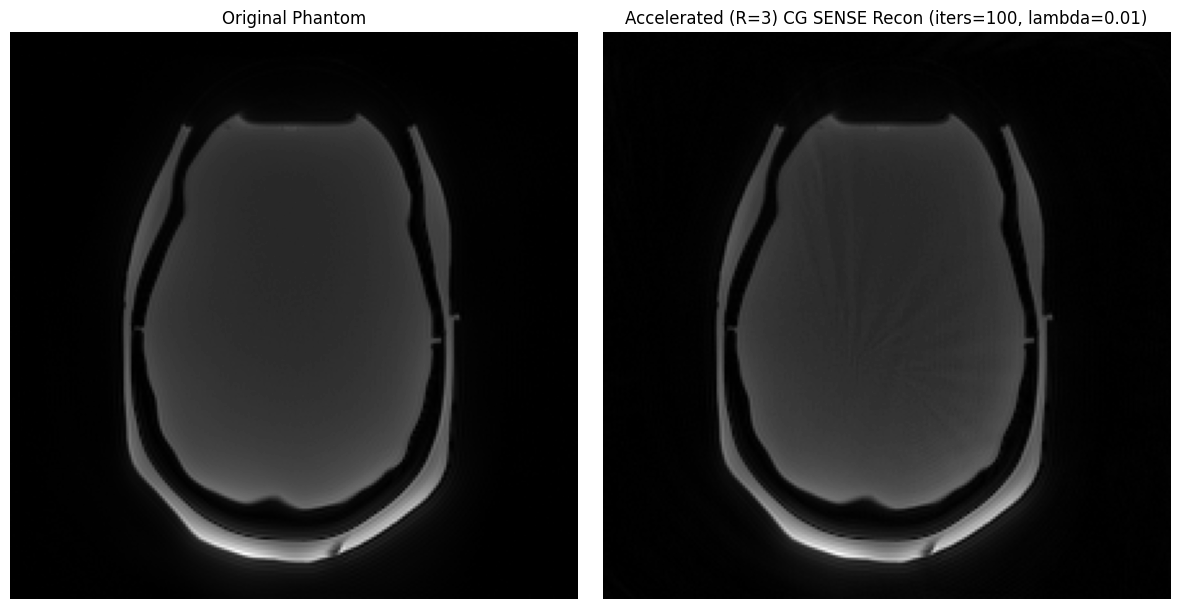

PSNR (R=3): 47.7423 dB
SSIM (R=3): 0.9736


In [ ]:

# -----------------------------------------------------------------
# 4) Reconstruct from ACCELERATED loaded k-space
# -----------------------------------------------------------------
# Reconstruction parameters (adjust as needed)
max_iter = 100
lamda_l2 = 1e-2  # L2 regularization strength
max_eigen = 1 # Estimate max eigenvalue automatically
tol = 1e-2

# Perform CG SENSE reconstruction from ACCELERATED data
# Use operator 'A_acc' and undersampled k-space 'ksp_acc'
recon = CG_SENSE_recon(
    A_acc,       # SENSE operator for accelerated data
    ksp_acc,     # Undersampled k-space data
    max_iter=max_iter,
    lamda_l2=lamda_l2,
    max_eigen=max_eigen,
    verbose=True,
    tolerance=tol
)

# recon now holds the reconstructed image from accelerated data

# -----------------------------------------------------------------
# 5) Visualize the reconstruction
# -----------------------------------------------------------------
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_torch.abs().cpu().numpy(), cmap='gray')
plt.title('Original Phantom')
plt.axis('off')

plt.subplot(1, 2, 2)
# Normalize recon for display relative to original
recon_norm = normalize(recon.cpu(), img_torch.cpu())
plt.imshow(recon_norm.abs().numpy(), cmap='gray')
plt.title(f'Accelerated (R={R}) CG SENSE Recon (iters={max_iter}, lambda={lamda_l2})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate PSNR and SSIM
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Ensure images are numpy arrays and use absolute values
img_np = img_torch.abs().cpu().numpy()
recon_np = recon_norm.abs().cpu().numpy() # recon_norm is already on CPU

# Calculate data range based on the original image
data_range = img_np.max() - img_np.min()

# Calculate PSNR
psnr_val = peak_signal_noise_ratio(img_np, recon_np, data_range=data_range)

# Calculate SSIM
# Note: SSIM is typically calculated on grayscale images.
# If images have multiple channels, specify multichannel=True if appropriate.
# Assuming single channel (magnitude image) here.
ssim_val = structural_similarity(img_np, recon_np, data_range=data_range)

print(f"PSNR (R={R}): {psnr_val:.4f} dB")
print(f"SSIM (R={R}): {ssim_val:.4f}")

# (Optional) Visualize the difference if still needed, but PSNR/SSIM are now the primary metrics
# diff = np.abs(img_np - recon_np)
# max_diff = diff.max()
# plt.figure()
# plt.imshow(diff, cmap='magma', vmax=max_diff / 2) # Adjust vmax for visibility
# plt.title(f'Absolute Difference Image (R={R} Acceleration)')
# plt.colorbar()
# plt.axis('off')
# plt.show()

## PMR

In [ ]:
n_monte = 20
sigma = 1e-2
# tol = 1e-2
recon_acc = lambda ksp : CG_SENSE_recon(A_acc, ksp, max_iter, lamda_l2, max_eigen, verbose=False,tolerance=tol)
recon_ref = lambda ksp : CG_SENSE_recon(A, ksp, max_iter, lamda_l2, max_eigen, verbose=False,tolerance=tol)

start_time = time.time()
# var_PMR = calc_variance_PMR(R=recon_acc, ksp=ksp_acc,
#                           noise_var=sigma ** 2, n_replicas=n_monte, verbose=True)
g_PMR = gfactor_SENSE_PMR(R_ref=recon_ref,
                          R_acc=recon_acc,
                          ksp_ref=ksp_torch,
                          ksp_acc=ksp_acc,
                          noise_var=sigma ** 2,
                          n_replicas=n_monte,
                          verbose=True)
end_time = time.time()
pmr_time = end_time - start_time
print(f"PMR with {n_monte} replicas took {pmr_time:.2f} seconds")



PMR Loop:  10%|█         | 2/20 [00:00<00:01, 11.42it/s]

tensor(10.9539, device='cuda:0')
tensor(10.9553, device='cuda:0')


PMR Loop:  10%|█         | 2/20 [00:00<00:01, 15.60it/s]

tensor(6.3217, device='cuda:0')
tensor(6.3176, device='cuda:0')


PMR Loop: 100%|██████████| 20/20 [00:01<00:00, 15.65it/s]

PMR with 20 replicas took 2.73 seconds


## Reference G-Factor with PMR with 2000 replicas

In [ ]:
n_monte_ref = 2000

# Measure time for reference method
start_time = time.time()
# var_ref = calc_variance_PMR(R=recon_acc, ksp=ksp_acc,
#                             noise_var=sigma ** 2, n_replicas=n_monte_ref, verbose=True)
g_ref = gfactor_SENSE_PMR(R_ref=recon_ref,
                          R_acc=recon_acc,
                          ksp_ref=ksp_torch,
                          ksp_acc=ksp_acc,
                          noise_var=sigma ** 2,
                          n_replicas=n_monte_ref,
                          verbose=True)
end_time = time.time()
ref_time = end_time - start_time
print(f"Reference method with {n_monte_ref} replicas took {ref_time:.2f} seconds")

PMR Loop:   1%|          | 2/200 [00:00<00:13, 14.66it/s]

tensor(10.9464, device='cuda:0')
tensor(10.9500, device='cuda:0')


PMR Loop:   1%|          | 2/200 [00:00<00:13, 14.51it/s]

tensor(6.3171, device='cuda:0')
tensor(6.3075, device='cuda:0')


PMR Loop: 100%|██████████| 200/200 [00:12<00:00, 15.67it/s]

Reference method with 200 replicas took 26.25 seconds


## Comparing All Methods

Time for Reference (MC): 26.25 seconds
Time for Monte Carlo: 2.73 seconds
Time for Hutchinson's: 2.30 seconds
=== Similarity Metrics ===
NRMSE % (Analytical vs. Monte Carlo): 13.1627
Pearson Correlation (Analytical vs. Monte Carlo): 28.1689

NRMSE % (Analytical vs. Hutchinson's): 11.9111
Pearson Correlation (Analytical vs. Hutchinson's): 31.1271

SSIM (Analytical vs. Monte Carlo): 0.0612
SSIM (Analytical vs. Hutchinson's): 0.0719


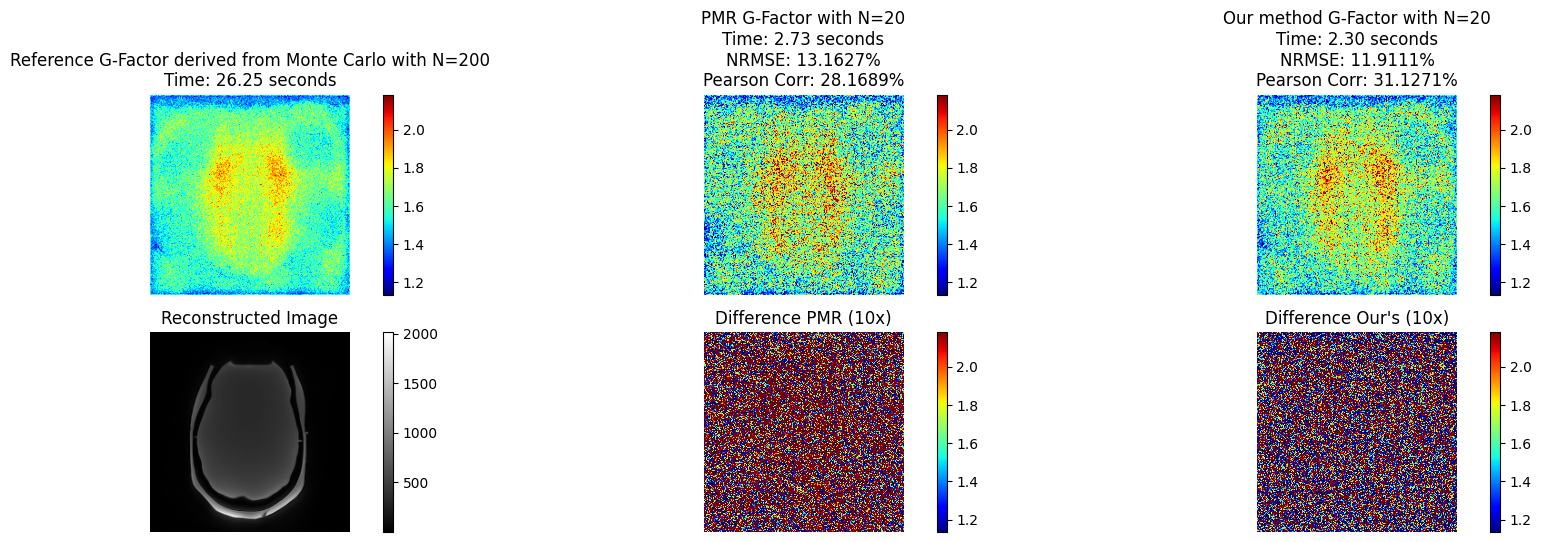

{'nrmse_analytical_monte': 13.1626799629836,
 'nrmse_analytical_hutch': 11.911092656542706,
 'corr_analytical_monte': 28.168879575690013,
 'corr_analytical_hutch': 31.12711097611818}

In [ ]:
from mr_recon.iqa import compare_g_factors
# results = compare_g_factors(std_ref, std_PMR, std_diag_comp_norm, n_monte=n_monte,n_monte_ref=n_monte_ref, time_g=ref_time, time_monte=pmr_time, time_hutch=diag_time, plot=True, recon_image=img_torch)
#consider 1/g factors
# compare_g_factors(1/g_ref, 1/g_PMR, 1/g_diag, n_monte=n_monte,n_monte_ref=n_monte_ref, time_g=ref_time, time_monte=pmr_time, time_hutch=diag_time, plot=True, recon_image=img_torch)

compare_g_factors(g_ref, g_PMR, g_diag, n_monte=n_monte,n_monte_ref=n_monte_ref, time_g=ref_time, time_monte=pmr_time, time_hutch=diag_time, plot=True, recon_image=img_torch)